In [1]:
import os
from glob import glob
import pickle

import dask.bag as db
import dask.dataframe as dd
import xarray as xr
import pandas as pd
import geopandas
import numpy as np
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from mitequinox.utils import *

#root_dir = '/home1/datawork/xyu/Drifters/'
#root_dir = '/Users/aponte/data/drifters/'
#data_dir = root_dir+'drifter_data_v1.02/'
data_dir = '/home/mp/pontea/scratch/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, walltime='12:00:00', memory='10GB')
w = cluster.scale(40)
#w = cluster.scale(5) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [5]:
client

Client Scheduler: tcp://10.135.39.59:60192 Dashboard: http://10.135.39.59:8787/status,Cluster Workers: 40 Cores: 40 Memory: 400.00 GB


In [16]:
#client.close()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---
## utils

In [2]:
def load_trajectory(ij, ncfile):
    ds = xr.open_dataset(ncfile).isel(TIME=slice(ij[0],ij[1]-1))
    df = ds.to_dataframe()
    id = int(df['ID'][0])
    df = df.drop(columns='ID')
    return df, id

def store(d):
    file = data_dir+'drifters/d_%d.p' %d[1]
    pickle.dump( d, open( file, 'wb' ) , protocol=-1)

In [3]:
RADIUS_EARTH = 6378.0
deg2rad = np.pi / 180.
def haversine(lon1, lat1, lon2, lat2):
    """Computes the Haversine distance in kilometres between two points
    :param x: first point or points as array, each as array of latitude, longitude in degrees
    :param y: second point or points as array, each as array of latitude, longitude in degrees
    :return: distance between the two points in kilometres
    """
    llat1 = lat1 * deg2rad
    llat2 = lat2 * deg2rad
    llon1 = lon1 * deg2rad
    llon2 = lon2 * deg2rad
    arclen = 2 * np.arcsin(np.sqrt((np.sin((llat2 - llat1) / 2)) ** 2 +
                                   np.cos(llat1) * np.cos(llat2) * (np.sin((llon2 - llon1) / 2)) ** 2))
    return arclen * RADIUS_EARTH

In [ ]:
def cross_traj(d1, iD):
    D = [pickle.load(open(f, 'rb')) for f in files[iD]]
    out = []
    for d in D:
        d2 = d[0]
        try:
            df = d1[0].join(d2, how='inner',lsuffix='_l',rsuffix='_r')
            # groupby block of time and average
            #dj = dj.groupby(pd.Grouper(freq='10D'))
            #dj = dj.resample('10D').mean()
            if not df.empty:
                # compute distance
                df['r'] = haversine(df['LON_l'],df['LAT_l'], 
                                    df['LON_r'],df['LAT_r'])
                if not df[df['r']<300].empty:
                    out.append([d[1],d1[1]])
        except:
            out.append([d[1],d1[1],'error'])
    if out:
        return out

In [ ]:
def load_pair(p):
    d0, id0 = pickle.load(open(data_dir+'drifters/%d.p'%p[0], 'rb'))
    d1, id1 = pickle.load(open(data_dir+'drifters/%d.p'%p[1], 'rb'))
    # get rid of gaps and interpolate if necessary
    d0 = d0[~pd.isnull(d0.index)]
    d1 = d1[~pd.isnull(d1.index)]
    #
    d0, d1 = d0.align(d1, join='inner')
    # fill gaps, should keep track of this
    d0 = d0.resample('H').interpolate('linear')
    d1 = d1.resample('H').interpolate('linear')
    # could convert to geopandas here
    gd0 = geopandas.GeoDataFrame(d0, geometry=geopandas.points_from_xy(
        d0.LON, d0.LAT))
    gd1 = geopandas.GeoDataFrame(d1, geometry=geopandas.points_from_xy(
        d1.LON, d1.LAT))
    return gd0, gd1

---

## rewrite hourly data

### inspect single file

In [4]:
ncfile = data_dir+'driftertrajWMLE_1.02_block1.nc'
ds = xr.open_dataset(ncfile)
print(ds)
print(ds.note)

<xarray.Dataset>
Dimensions:  (TIME: 15230718)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2005-04-15T20:00:00 ... NaT
Data variables:
    ID       (TIME) float64 ...
    LAT      (TIME) float64 ...
    LON      (TIME) float64 ...
    U        (TIME) float64 ...
    V        (TIME) float64 ...
    LAT_ERR  (TIME) float64 ...
    LON_ERR  (TIME) float64 ...
    U_ERR    (TIME) float64 ...
    V_ERR    (TIME) float64 ...
    GAP      (TIME) timedelta64[ns] ...
    RMSGAP   (TIME) timedelta64[ns] ...
    DROGUE   (TIME) float64 ...
Attributes:
    title:        Hourly Argos-tracked drifters location and velocity estimat...
    description:  This is version 1.02, block 1 of the dataset. See http://ww...
    note:         For all variables of dimension TIME, interruptions in the e...
    creator:      Shane Elipot and Rick Lumpkin
    timestamp:    19-Dec-2018 13:25:49
For all variables of dimension TIME, interruptions in the estimation along a single trajectory are indicated by "Inf" v

In [5]:
inan = np.where(np.isnan(ds.LAT.values))[0]
b = (db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)], 
                      npartitions=1000)
     .map(load_trajectory, ncfile))
b.take(1)[0][0].head()

,LAT,LON,U,V,LAT_ERR,LON_ERR,U_ERR,V_ERR,GAP,RMSGAP,DROGUE
TIME,,,,,,,,,,,
2005-04-15 20:00:00,47.47501,312.05118,-0.1733,0.2009,0.01129,0.04254,0.0,0.0,00:54:43.200000,01:08:24,1.0
2005-04-15 21:00:00,47.46839,312.04200,-0.1616,-0.5554,0.00987,0.01140,0.0,0.0,01:04:48,00:58:12,1.0
2005-04-15 22:00:00,47.44858,312.03870,0.8653,-0.5284,0.00537,0.01501,0.0,0.0,00:33:07.200000,00:47:38.400000,1.0
2005-04-15 23:00:00,47.43282,312.07433,0.4313,-0.4776,0.00058,0.00803,0.0,0.0,00:28:48,00:49:33.600000,1.0
2005-04-16 00:00:00,47.41716,312.07013,0.0575,-0.4887,0.00049,0.00729,0.0,0.0,01:12:00,00:57:18,1.0


### process all nc block files

In [12]:
for ifile in range(1,8):
    ncfile = data_dir+'driftertrajWMLE_1.02_block%d.nc' %ifile
    #
    ds = xr.open_dataset(ncfile)
    inan = np.where(np.isnan(ds.LAT.values))[0]
    #
    b = (db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)], 
                          npartitions=1000)
         .map(load_trajectory, ncfile))
    b.map(store).compute()
    print(ncfile)

/home/mp/pontea/scratch/driftertrajWMLE_1.02_block1.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block2.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block3.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block4.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block5.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block6.nc
/home/mp/pontea/scratch/driftertrajWMLE_1.02_block7.nc


In [12]:
cluster.close()

---

## reload files and search for temporal and geographical proximity

In [30]:
#files = glob('data/*.nc')
files = glob(data_dir+'drifters/d_*.p')
files = [f for f in files if 'pairs' not in f]
print(len(files))

12287


### profile with few pairs

In [12]:
Nc = 10
i=0
iD = slice(i, min(i+Nc,len(files)))
%time b = ( db.from_sequence(files[:],npartitions=1000) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
%time lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 22.2 ms, sys: 2.02 ms, total: 24.2 ms
Wall time: 23.1 ms
CPU times: user 7.04 ms, sys: 1 ms, total: 8.04 ms
Wall time: 7.11 ms
CPU times: user 1min 16s, sys: 1.59 s, total: 1min 17s
Wall time: 1min 53s


In [13]:
iD = slice(i, min(i+Nc,len(files)))
b = ( db.from_sequence(files[:],npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 21.6 ms, sys: 29 µs, total: 21.6 ms
Wall time: 18.9 ms
CPU times: user 9.3 ms, sys: 1.04 ms, total: 10.3 ms
Wall time: 8.49 ms
CPU times: user 12.6 s, sys: 520 ms, total: 13.2 s
Wall time: 1min 1s


Best answer:

In [15]:
Nc = 100
iD = slice(i, min(i+Nc,len(files)))
b = ( db.from_sequence(files[:],npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )
lb = b.map(cross, iD)
%time p = lb.compute()

CPU times: user 85.1 ms, sys: 2.03 ms, total: 87.1 ms
Wall time: 83.1 ms
CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 10.7 ms
CPU times: user 1min 45s, sys: 4.03 s, total: 1min 49s
Wall time: 8min 27s


### process all pairs

In [41]:
# loop around groups of drifters and
Nc = 100
i0 = 0 # historic restart at 730
for i in range(i0,len(files),Nc):
    
    file = data_dir+'drifters/pairs_%d.p' %i
    
    if not os.path.isfile(file):

        iD = slice(i, min(i+Nc,len(files)))

        # load dask bag
        b = ( db.from_sequence(files[i+1:], npartitions=100)
              .map(lambda f: pickle.load(open(f, 'rb'))) )

        # cross data
        p = b.map(cross, iD).compute()
        p = [llp for lp in p if lp is not None for llp in lp]
        p = [lp for lp in p if (lp[0]!=lp[1])]

        pickle.dump( p, open( file, 'wb' ) , protocol=-1)
    
    print('%d / %d'%(i,len(files)))

730 / 12287
830 / 12287
930 / 12287
1030 / 12287
1130 / 12287
1230 / 12287
1330 / 12287
1430 / 12287
1530 / 12287
1630 / 12287
1730 / 12287
1830 / 12287
1930 / 12287
2030 / 12287
2130 / 12287
2230 / 12287
2330 / 12287
2430 / 12287
2530 / 12287
2630 / 12287
2730 / 12287
2830 / 12287
2930 / 12287
3030 / 12287
3130 / 12287
3230 / 12287
3330 / 12287
3430 / 12287
3530 / 12287
3630 / 12287
3730 / 12287
3830 / 12287
3930 / 12287
4030 / 12287
4130 / 12287
4230 / 12287
4330 / 12287
4430 / 12287
4530 / 12287
4630 / 12287
4730 / 12287
4830 / 12287
4930 / 12287
5030 / 12287
5130 / 12287
5230 / 12287
5330 / 12287
5430 / 12287
5530 / 12287
5630 / 12287
5730 / 12287
5830 / 12287
5930 / 12287
6030 / 12287
6130 / 12287
6230 / 12287
6330 / 12287
6430 / 12287
6530 / 12287
6630 / 12287
6730 / 12287
6830 / 12287
6930 / 12287
7030 / 12287
7130 / 12287
7230 / 12287
7330 / 12287
7430 / 12287
7530 / 12287
7630 / 12287
7730 / 12287
7830 / 12287
7930 / 12287
8030 / 12287
8130 / 12287
8230 / 12287
8330 / 12287
84

In [16]:
# concatenate all pairs files into one
pfiles = glob(data_dir+'drifters/pairs_*.p')
len(pfiles)

189

In [17]:
pairs = []
for f in pfiles:
    pairs+=pickle.load(open(f, 'rb'))
len(pairs)

107490

In [ ]:
# concatenating is not necessary:
#pickle.dump( pairs, open(data_dir+'drifters/pairs.p' , 'wb' ) , protocol=-1)

### gather stats about pairs and store

In [45]:
d0, d1 = load_pair(pairs[1])

In [41]:
#d0[pd.isnull(d0.index)]

In [42]:
d0.head()

,LAT,LON,U,V,LAT_ERR,LON_ERR,U_ERR,V_ERR,GAP,RMSGAP,DROGUE,geometry
TIME,,,,,,,,,,,,
2011-03-12 17:00:00,26.50681,308.80461,0.4897,-0.0682,0.00020,0.00254,0.1103,0.0058,01:04:48,00:56:27.600000,1.0,POINT (308.80461 26.50681)
2011-03-12 18:00:00,26.50490,308.82241,0.5235,-0.0457,0.00086,0.00452,0.2075,0.0348,00:33:07.200000,01:09:50.400000,1.0,POINT (308.82241 26.5049)
2011-03-12 19:00:00,26.50416,308.84088,0.3725,0.0096,0.00069,0.00510,0.0680,0.0094,01:30:43.200000,01:28:40.800000,1.0,POINT (308.84088 26.50416)
2011-03-12 20:00:00,26.50467,308.85416,0.3809,0.0187,0.00034,0.00264,0.0513,0.0046,01:33:36,01:55:04.800000,1.0,POINT (308.85416 26.50467)
2011-03-12 21:00:00,26.50501,308.86902,0.3898,0.0179,0.00045,0.00224,0.0468,0.0050,01:33:36,01:46:37.200000,1.0,POINT (308.86902 26.50501)


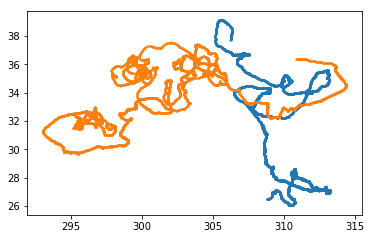

In [44]:
ax = plt.subplot(111)
d0.plot(ax=ax, markersize=1)
d1.plot(ax=ax, markersize=1)

## old code, gather stats about single trajectories

In [ ]:
ncfile = data_dir+'driftertrajWMLE_1.02_block1.nc'
ds = xr.open_dataset(ncfile)
#
inan = np.where(np.isnan(ds.LAT.values))[0]
#
b = (db.from_sequence([(i+1,j) for i,j in zip(np.hstack([-1,inan])[:-1],inan)], 
                      npartitions=1000)
     .map(load_trajectory, ncfile))
b.take(1)[0][0].head()

In [77]:
def row(d):
    d0 = d.isel(TIME=0)
    d1 = d.isel(TIME=-1)
    dmean = d.mean(dim='TIME')
    return {'index': int(d.ID), 't0': d0.TIME.values, 't1': d1.TIME.values, 
            'lon0': d0.LON.values, 'lat0': d0.LAT.values,
            'lon1': d1.LON.values, 'lat1': d1.LAT.values, 
            'lonm': dmean.LON.values, 'latm': dmean.LAT.values}

In [78]:
df = b.map(row).to_dataframe()

In [79]:
df.head()

,index,lat0,lat1,latm,lon0,lon1,lonm,t0,t1
0,72225,-60.68735,-55.37916,inf,301.60824,323.67344,inf,2008-01-13 11:00:00,2008-08-15 01:00:00
1,139959,-38.35795,-33.17749,-34.802871778588106,212.48165,255.8217,230.78878613020854,2015-09-22 13:00:00,2018-07-05 11:00:00
2,103796,50.98836,52.30275,50.626032906868815,316.8033,350.06815,328.7902196875,2011-04-27 12:00:00,2012-01-21 19:00:00
3,36006,49.23945,47.925,inf,194.31873,220.93793,inf,2003-07-17 22:00:00,2004-10-01 00:00:00
4,90626,47.69302,47.49114,47.16451342971087,307.84693,308.3916,308.0917311714856,2009-05-06 23:00:00,2009-07-29 12:00:00


In [12]:
df = df.repartition(npartitions=1)
#df.npartitions

In [13]:
df.to_csv(data_dir+'drifters/bounds-*.csv', mode='w')

['/home/mp/pontea/scratch/drifters/bounds-0.csv']

### read stats

In [60]:
df = ( pd.read_csv(data_dir+'drifters/bounds-0.csv', parse_dates=[6,7])
       .set_index('index').drop(columns='Unnamed: 0') )
len(df)

12287

In [51]:
df.head()

,lat0,lat1,lon0,lon1,t0,t1
index,,,,,,
72225,-60.68735,-55.37916,301.60824,323.67344,2008-01-13 11:00:00,2008-08-15 01:00:00
139959,-38.35795,-33.17749,212.48165,255.82170,2015-09-22 13:00:00,2018-07-05 11:00:00
103796,50.98836,52.30275,316.80330,350.06815,2011-04-27 12:00:00,2012-01-21 19:00:00
36006,49.23945,47.92500,194.31873,220.93793,2003-07-17 22:00:00,2004-10-01 00:00:00
90626,47.69302,47.49114,307.84693,308.39160,2009-05-06 23:00:00,2009-07-29 12:00:00


In [55]:
#for id, row in df.iterrows():
#    print(type(row))b = 
b = db.from_sequence(df.iterrows())

In [56]:
b.take(1)

((72225, lat0               -60.6874
  lat1               -55.3792
  lon0                301.608
  lon1                323.673
  t0      2008-01-13 11:00:00
  t1      2008-08-15 01:00:00
  Name: 72225, dtype: object),)

In [40]:
item = b.take(1)
t0, t1 = item[0][1]['t0'], item[0][1]['t1']

In [69]:
dt = datetime.timedelta(days=10)

In [73]:
def cross(item):
    id = item[0]
    t0 = item[1]['t0']
    t1 = item[1]['t1']
    #
    df = ( pd.read_csv(data_dir+'drifters/bounds-0.csv', parse_dates=[6,7])
           .set_index('index').drop(columns='Unnamed: 0') )
    df = df[~( (df.t1<t0+dt) | (df.t0>t1-dt) )]
    return len(df)

In [71]:
out = b.map(cross).compute()

(array([1.281e+03, 5.410e+03, 3.457e+03, 1.152e+03, 5.590e+02, 2.660e+02,
        1.060e+02, 5.300e+01, 2.000e+00, 1.000e+00]),
 array([1.0000e+00, 8.5230e+02, 1.7036e+03, 2.5549e+03, 3.4062e+03,
        4.2575e+03, 5.1088e+03, 5.9601e+03, 6.8114e+03, 7.6627e+03,
        8.5140e+03]),
 <a list of 10 Patch objects>)

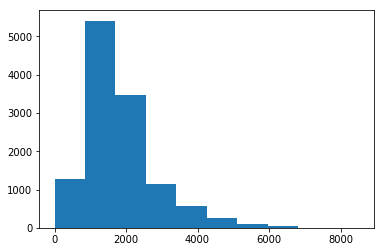

In [72]:
plt.hist(out)

---

## old form bag of pairs, brute force, does not work

In [14]:
import itertools

In [ ]:
#b = (db.from_sequence(itertools.combinations(files, 2))
#    .map(lambda files: [xr.open_dataset(files[0]), xr.open_dataset(files[1])]))
b = (db.from_sequence(itertools.combinations(files, 2),npartitions=1000)
    .map(lambda files: [files[0], files[1]]))
b

In [121]:
b.take(1)

(['data/drifter_9729742.p', 'data/drifter_25763.p'],)

In [122]:
def flatten(p):
    ds0 = pickle.load(open(p[0], 'rb'))
    ds1 = pickle.load(open(p[1], 'rb'))
    #ds0 = xr.open_dataset(p[0], lock=False)
    #ds1 = xr.open_dataset(p[1], lock=False)
    #ds0 = Dataset(p[0])
    #ds1 = Dataset(p[1])
    return {
        'id0': int(ds0.ID.values),
        'id1': int(ds1.ID.values),
        '0_t0': ds0.isel(TIME=0).TIME.values,
        '0_t1': ds0.isel(TIME=-1).TIME.values,
        '1_t0': ds1.isel(TIME=0).TIME.values,
        '1_t1': ds1.isel(TIME=-1).TIME.values
    }
#        'id0': p[0],
#        'id1': p[1]
#        'p0_t0': p[0].isel(TIME=0).TIME.values,
#        'p0_t1': p[0].isel(TIME=-2).TIME.values,
#        'p1_t0': p[1].isel(TIME=0).TIME.values,
#        'p1_t1': p[1].isel(TIME=-2).TIME.values
b.map(flatten).take(1)

({'id0': 9729742,
  'id1': 25763,
  '0_t0': numpy.datetime64('1998-02-06T05:00:00.000000000'),
  '0_t1': numpy.datetime64('2001-02-15T16:00:00.000000000'),
  '1_t0': numpy.datetime64('2001-03-30T03:00:00.000000000'),
  '1_t1': numpy.datetime64('2004-11-07T17:00:00.000000000')},)

In [123]:
df = b.map(flatten).to_dataframe()

In [124]:
df.head()

,0_t0,0_t1,1_t0,1_t1,id0,id1
0,1998-02-06 05:00:00,2001-02-15 16:00:00,2001-03-30 03:00:00,2004-11-07 17:00:00,9729742,25763
1,1998-02-06 05:00:00,2001-02-15 16:00:00,2002-04-01 01:00:00,2005-03-23 03:00:00,9729742,34160
2,1998-02-06 05:00:00,2001-02-15 16:00:00,2005-05-25 21:00:00,2005-10-12 23:00:00,9729742,2556428
3,1998-02-06 05:00:00,2001-02-15 16:00:00,2003-01-17 04:00:00,2005-01-15 13:00:00,9729742,36960
4,1998-02-06 05:00:00,2001-02-15 16:00:00,2002-05-01 10:00:00,2003-12-02 22:00:00,9729742,32042


In [ ]:
#df.repartition(1000).to_csv('data/pairs-*.csv')
df.to_csv('data/pairs-*.csv', mode='w') # can be done